# Get Current Forecast

read out the forecast for different companies for today. Source of forecast data is [https://kursprognose.com](https://kursprognose.com)

In [1]:
from finance_monitor.forecastgrapper import ForecastGrapper
fcg = ForecastGrapper()

Forecast data saved to 20250515_nvidia_forecast.csv
Forecast data saved to 20250515_nvidia_forecast.csv
Current stock price of nvidia is 134.83 USD / 120.47 EUR


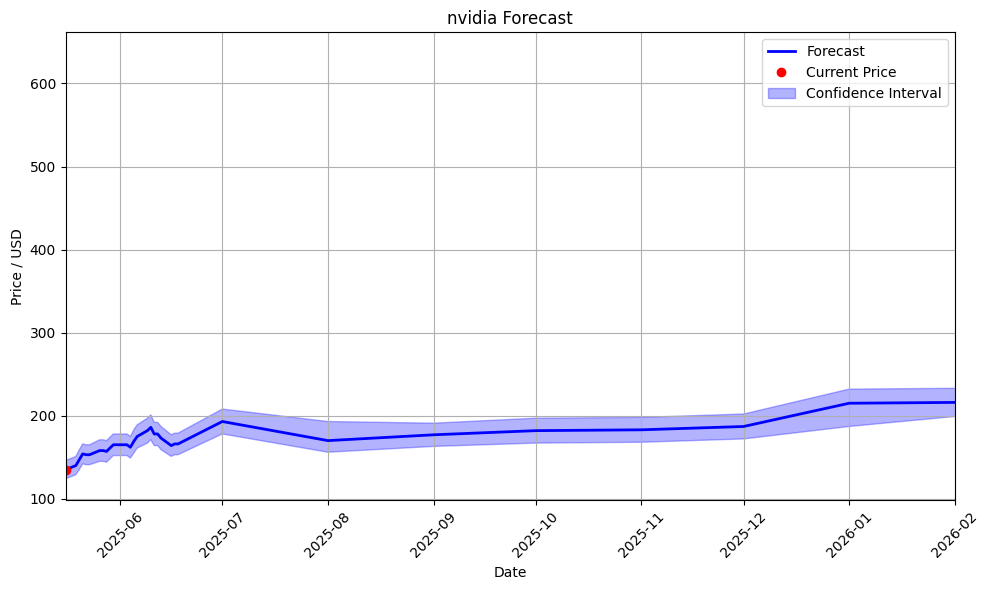

In [2]:
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250515_rhm-aktie_forecast.csv
Forecast data saved to 20250515_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1884.0 USD / 1683.35 EUR


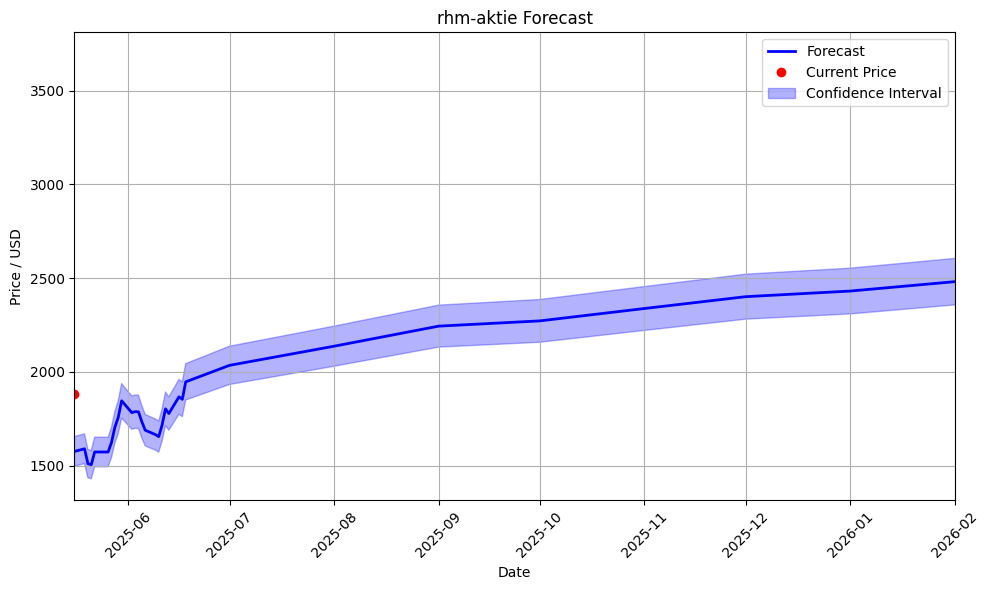

In [3]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250515_tesla_forecast.csv
Forecast data saved to 20250515_tesla_forecast.csv
Current stock price of tesla is 342.82 USD / 306.31 EUR


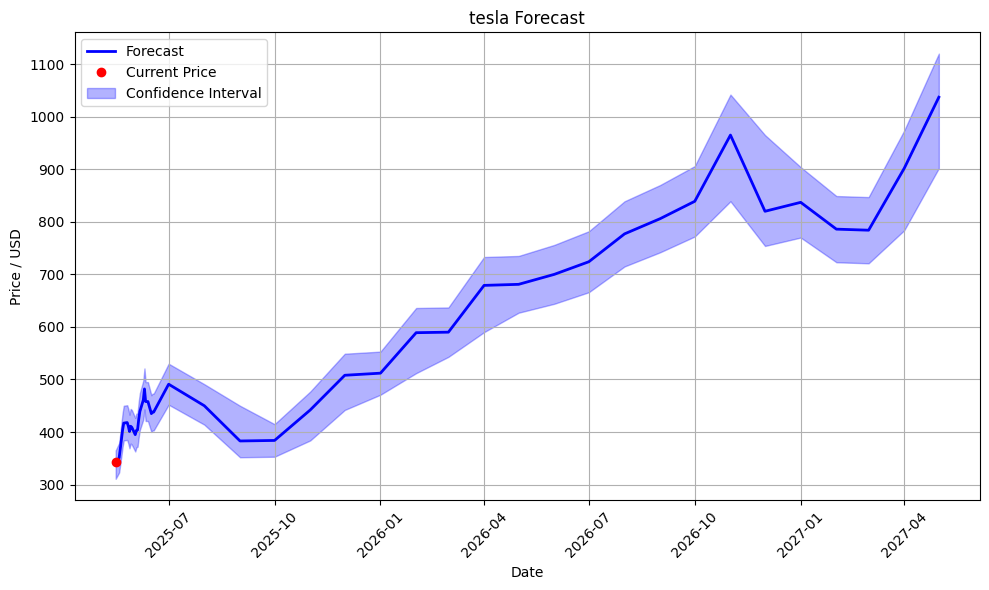

In [4]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250515_netflix_forecast.csv
Forecast data saved to 20250515_netflix_forecast.csv
Current stock price of netflix is 1177.98 USD / 1052.53 EUR


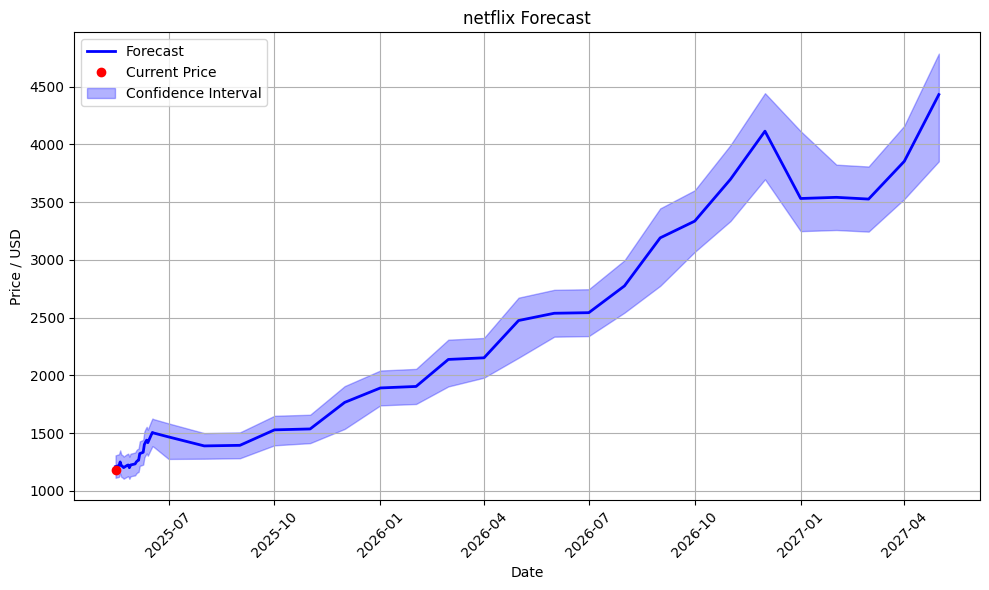

In [5]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250515_wmt-stock_forecast.csv
Forecast data saved to 20250515_wmt-stock_forecast.csv
Current stock price of wmt-stock is 96.35 USD / 86.09 EUR


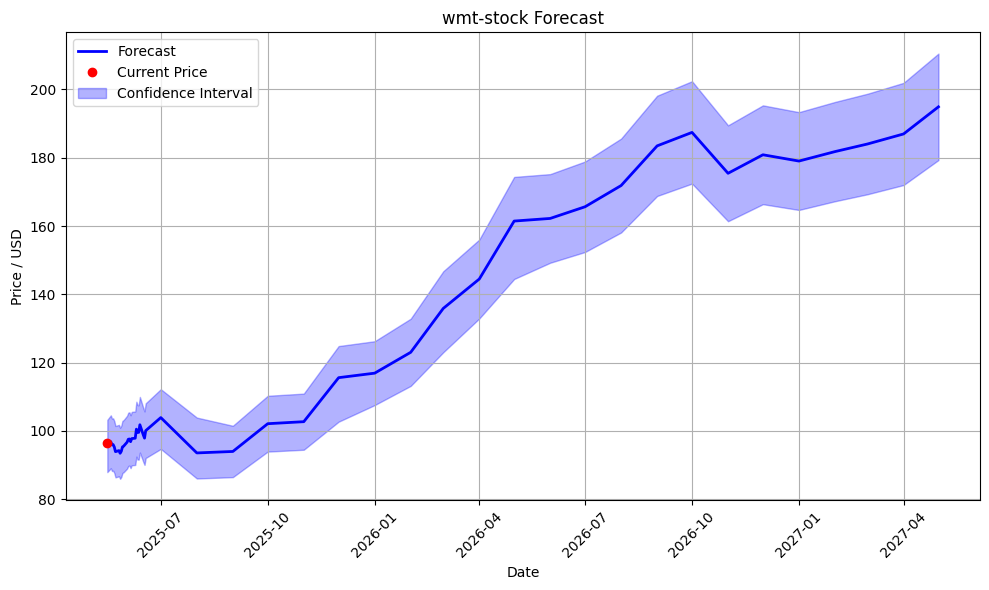

In [ ]:
# Walmart
fcg.set_company("wmt-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250515_xpeng_forecast.csv
Forecast data saved to 20250515_xpeng_forecast.csv
Current stock price of xpeng is 20.62 USD / 18.43 EUR


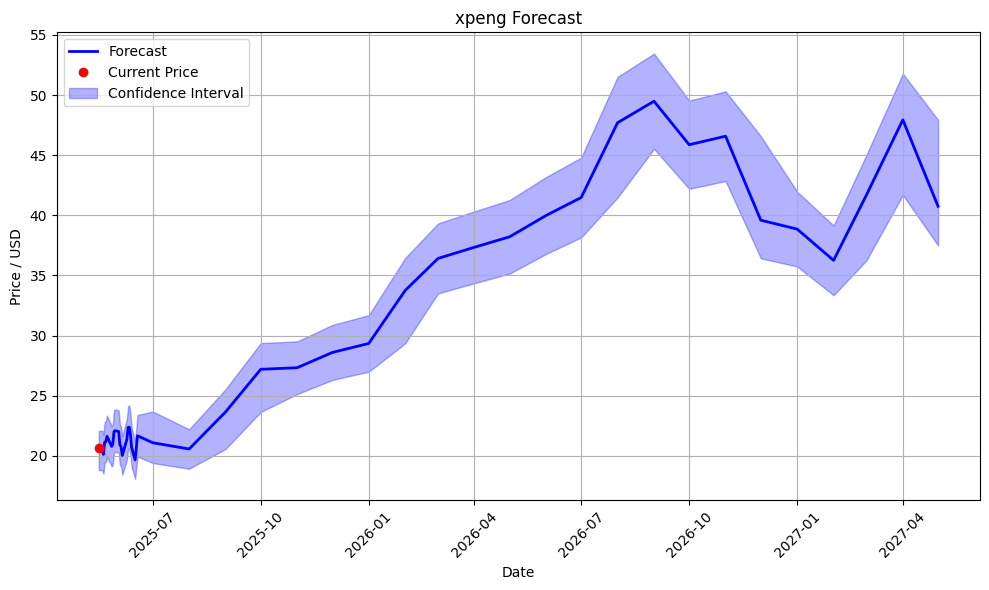

In [7]:
fcg.set_company("xpeng")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250515_mo-stock_forecast.csv
Forecast data saved to 20250515_mo-stock_forecast.csv
Current stock price of mo-stock is 58.06 USD / 51.89 EUR


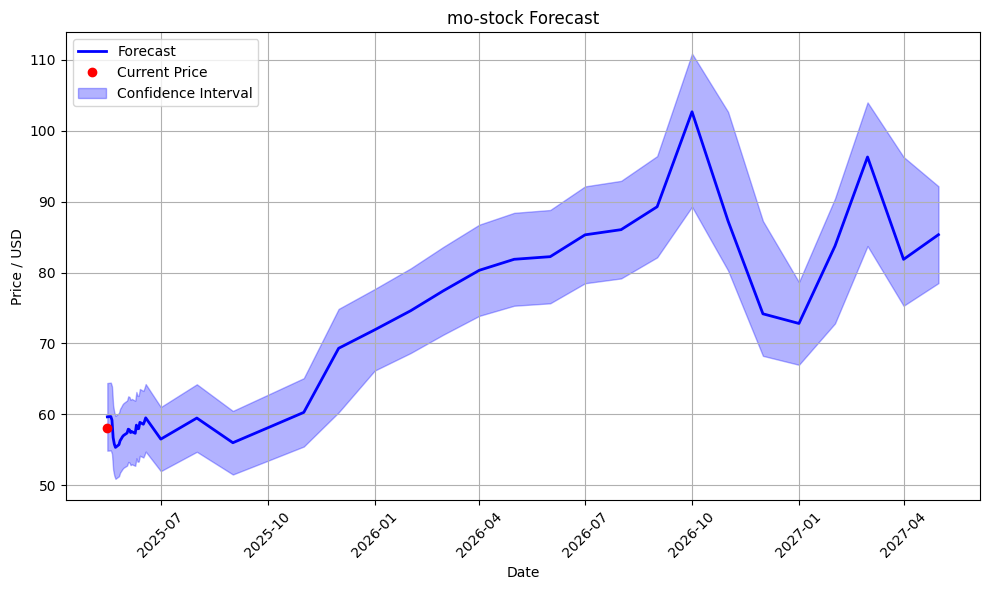

In [ ]:
# Altria Group
fcg.set_company("mo-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()